Setting Up the Environment and Dataset

In [2]:
# Install required packages
!pip install -q kaggle tensorflow matplotlib seaborn scikit-learn opencv-python

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import cv2
from google.colab import files
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Kaggle Dataset Setup

In [15]:
# Upload your kaggle.json file
!rm -rf ~/.kaggle
!rm -r kaggle.json
!rm -r kaggle\ \(1\).json
!rm -r kaggle\ \(2\).json
print("Please upload your kaggle.json file:")
files.upload()

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Remove any existing files first
!rm -rf "English Handwritten Characters Dataset"
!rm -f english-handwritten-characters-dataset.zip

# Then download again
!kaggle datasets download -d dhruvildave/english-handwritten-characters-dataset
!unzip -o -q english-handwritten-characters-dataset.zip

# Check the dataset structure
!ls -la


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset
License(s): ODbL-1.0
  0% 0.00/13.1M [00:00<?, ?B/s]
100% 13.1M/13.1M [00:00<00:00, 831MB/s]
total 13600
drwxr-xr-x 1 root root     4096 Jun 29 19:55 .
drwxr-xr-x 1 root root     4096 Jun 29 19:09 ..
drwxr-xr-x 4 root root     4096 Jun 26 13:34 .config
-rw-r--r-- 1 root root    71622 Feb 24  2021 english.csv
-rw-r--r-- 1 root root 13694607 Feb 24  2021 english-handwritten-characters-dataset.zip
drwxr-xr-x 2 root root   131072 Jun 29 19:55 Img
-rw-r--r-- 1 root root       68 Jun 29 19:55 kaggle.json
drwxr-xr-x 1 root root     4096 Jun 26 13:35 sample_data


Data Exploration and Understanding

In [18]:
import re

# Updated data exploration for filename-based labels
dataset_path = '/content/Img'

# Get all image files
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total image files found: {len(image_files)}")

# Analyze filename patterns to extract character labels
def extract_label_from_filename(filename):
    """Extract character label from filename"""
    match = re.search(r'img(\d+)-', filename)
    if match:
        return int(match.group(1))
    return None

def number_to_character(num):
    """Convert number to character based on standard encoding"""
    if 1 <= num <= 10:
        return str(num - 1)  # Digits 0-9
    elif 11 <= num <= 36:
        return chr(ord('A') + num - 11)  # A-Z
    elif 37 <= num <= 62:
        return chr(ord('a') + num - 37)  # a-z
    else:
        return f"unknown_{num}"

# Test the mapping with sample files
sample_labels = {}
for filename in image_files[:10]:
    label_num = extract_label_from_filename(filename)
    char_label = number_to_character(label_num) if label_num else None
    sample_labels[filename] = char_label

print(f"\nSample filename to character mapping:")
for filename, char in sample_labels.items():
    print(f"{filename} -> '{char}'")


Total image files found: 3410

Sample filename to character mapping:
img031-006.png -> 'U'
img013-027.png -> 'C'
img046-044.png -> 'j'
img006-019.png -> '5'
img050-022.png -> 'n'
img028-023.png -> 'R'
img012-035.png -> 'B'
img029-004.png -> 'S'
img016-036.png -> 'F'
img003-046.png -> '2'


Optional: Debug Section

In [20]:
# DEBUG: Check filename pattern extraction
print("=== DEBUGGING FILENAME EXTRACTION ===")
sample_files = image_files[:5]
for filename in sample_files:
    label_num = extract_label_from_filename(filename)
    char_label = number_to_character(label_num) if label_num else None
    print(f"{filename} -> num: {label_num} -> char: '{char_label}'")

# Check number range in your dataset
all_nums = []
for filename in image_files[:100]:  # Check first 100 files
    label_num = extract_label_from_filename(filename)
    if label_num is not None:
        all_nums.append(label_num)

if all_nums:
    print(f"Number range in dataset: {min(all_nums)} to {max(all_nums)}")
    print(f"Unique numbers found: {sorted(set(all_nums))[:20]}...")
else:
    print("ERROR: No valid numbers extracted from filenames")


=== DEBUGGING FILENAME EXTRACTION ===
img031-006.png -> num: 31 -> char: 'U'
img013-027.png -> num: 13 -> char: 'C'
img046-044.png -> num: 46 -> char: 'j'
img006-019.png -> num: 6 -> char: '5'
img050-022.png -> num: 50 -> char: 'n'
Number range in dataset: 1 to 62
Unique numbers found: [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 26]...


Data Visualization

Total character groups found: 62
Sample characters: ['U', 'C', 'j', '5', 'n', 'R', 'B', 'S', 'F', '2']


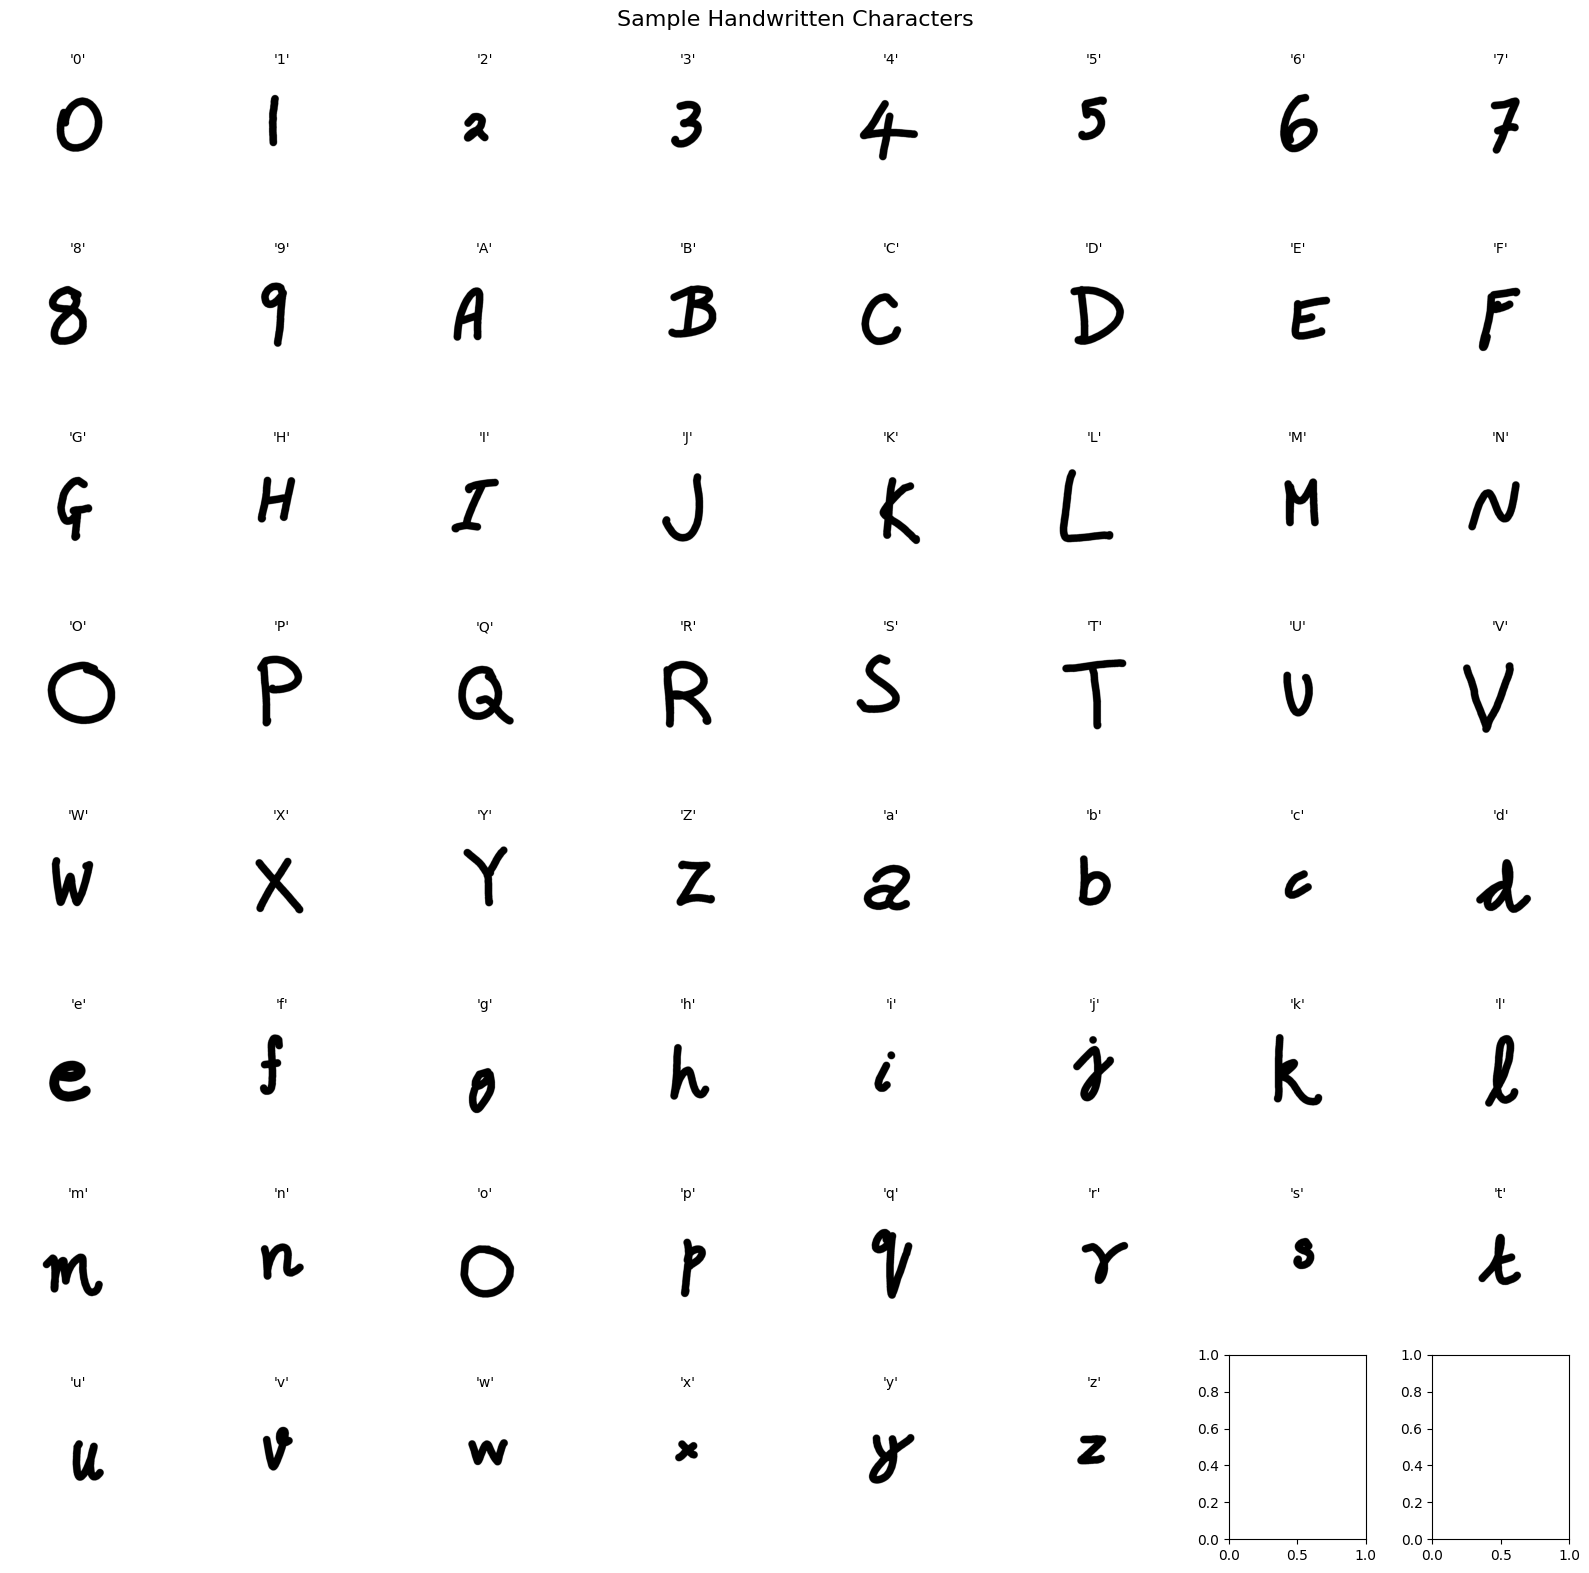


Character distribution:
'0': 55 images
'1': 55 images
'2': 55 images
'3': 55 images
'4': 55 images
'5': 55 images
'6': 55 images
'7': 55 images
'8': 55 images
'9': 55 images


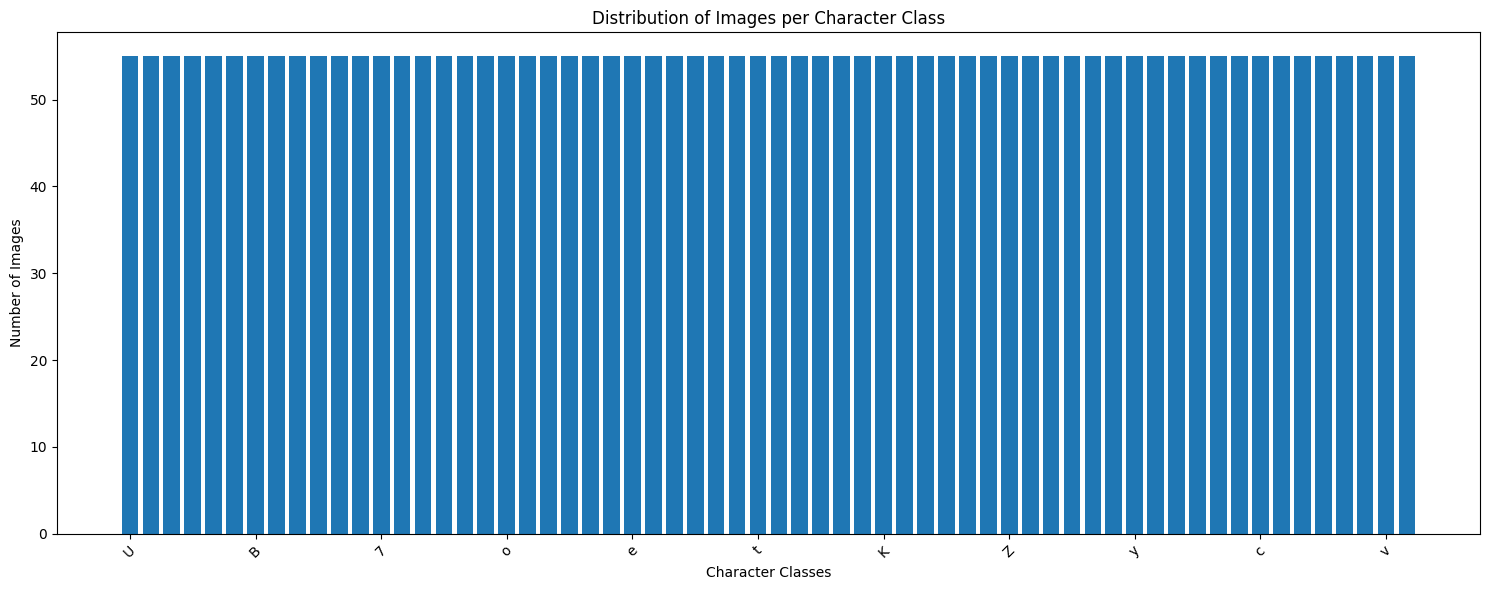

Average images per class: 55.00
Min images per class: 55
Max images per class: 55


In [22]:
# Visualize sample images from each class
def visualize_samples_from_files(dataset_path, image_files, samples_per_class=1):
    """Visualize sample images from filename-based dataset"""

    # Group files by character label
    char_groups = {}
    for filename in image_files:
        label_num = extract_label_from_filename(filename)
        char_label = number_to_character(label_num) if label_num else None

        if char_label is not None:  # Only check for None, not 'unknown'
            if char_label not in char_groups:
                char_groups[char_label] = []
            char_groups[char_label].append(filename)

    # Debug output
    print(f"Total character groups found: {len(char_groups)}")
    print(f"Sample characters: {list(char_groups.keys())[:10]}")

    # Sort characters for display
    sorted_chars = sorted(char_groups.keys())

    # Create visualization
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    fig.suptitle('Sample Handwritten Characters', fontsize=16)

    for idx, char in enumerate(sorted_chars[:64]):  # Show first 64 characters
        row = idx // 8
        col = idx % 8

        if char_groups[char]:
            # Load and display the first image for this character
            img_path = os.path.join(dataset_path, char_groups[char][0])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(f"'{char}'", fontsize=10)
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    # Print character distribution
    char_counts = {char: len(files) for char, files in char_groups.items()}
    print(f"\nCharacter distribution:")
    for char in sorted(char_counts.keys())[:10]:
        print(f"'{char}': {char_counts[char]} images")

    return char_groups # Return char_groups

# Call the function and get char_groups
char_groups = visualize_samples_from_files(dataset_path, image_files)

# Plot distribution of images per class - ERROR-SAFE VERSION
char_counts = {char: len(files) for char, files in char_groups.items()}

if char_counts:  # Check if dictionary is not empty
    plt.figure(figsize=(15, 6))
    classes = list(char_counts.keys())
    counts = list(char_counts.values())

    if len(classes) > 0 and len(counts) > 0:
        plt.bar(range(len(classes)), counts)
        plt.title('Distribution of Images per Character Class')
        plt.xlabel('Character Classes')
        plt.ylabel('Number of Images')

        # Safe x-tick labeling
        step = max(1, len(classes) // 10)  # Show ~10 labels max
        plt.xticks(range(0, len(classes), step),
                  [classes[i] for i in range(0, len(classes), step)],
                  rotation=45)

        plt.tight_layout()
        plt.show()

        print(f"Average images per class: {np.mean(counts):.2f}")
        print(f"Min images per class: {np.min(counts)}")
        print(f"Max images per class: {np.max(counts)}")
    else:
        print("ERROR: No valid character data found")
else:
    print("ERROR: char_counts dictionary is empty")

Data Loading and Preprocessing

In [23]:
def load_and_preprocess_data_from_files(dataset_path, img_size=(64, 64)):
    """Load and preprocess images when labels are in filenames"""
    images = []
    labels = []

    # Get all image files
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Loading {len(image_files)} images...")

    for img_file in image_files:
        # Extract label from filename
        label_num = extract_label_from_filename(img_file)

        if label_num is not None:
            # Convert number to character
            char_label = number_to_character(label_num)

            # Skip unknown labels
            if char_label.startswith('unknown'):
                continue

            # Load and preprocess image
            img_path = os.path.join(dataset_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                # Resize image
                img_resized = cv2.resize(img, img_size)

                # Normalize pixel values to [0, 1]
                img_normalized = img_resized.astype(np.float32) / 255.0

                # Add to lists
                images.append(img_normalized)
                labels.append(char_label)

    return np.array(images), np.array(labels)

# Load the data with updated function
print("Loading dataset with filename-based labels...")
X, y = load_and_preprocess_data_from_files(dataset_path)

print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Check label distribution
unique_labels, counts = np.unique(y, return_counts=True)
print(f"\nNumber of unique characters: {len(unique_labels)}")
print(f"Sample characters: {unique_labels[:10]}")

# Reshape images to add channel dimension (for CNN)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
print(f"Images shape after reshape: {X.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Class labels: {label_encoder.classes_[:10]}...")  # Show first 10 classes


Loading dataset with filename-based labels...
Loading 3410 images...
Images shape: (3410, 64, 64)
Labels shape: (3410,)

Number of unique characters: 62
Sample characters: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Images shape after reshape: (3410, 64, 64, 1)
Number of classes: 62
Class labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']...


Data Splitting and Augmentation

In [24]:
# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # Don't flip characters horizontally
    fill_mode='nearest'
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator()

# Create data generators
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val_cat, batch_size=batch_size)


Training set: 2387 samples
Validation set: 511 samples
Test set: 512 samples


Model Architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             

 Total params: 865,438 (3.30 MB)

 Trainable params: 862,942 (3.29 MB)

 Non-trainable params: 2,496 (9.75 KB)

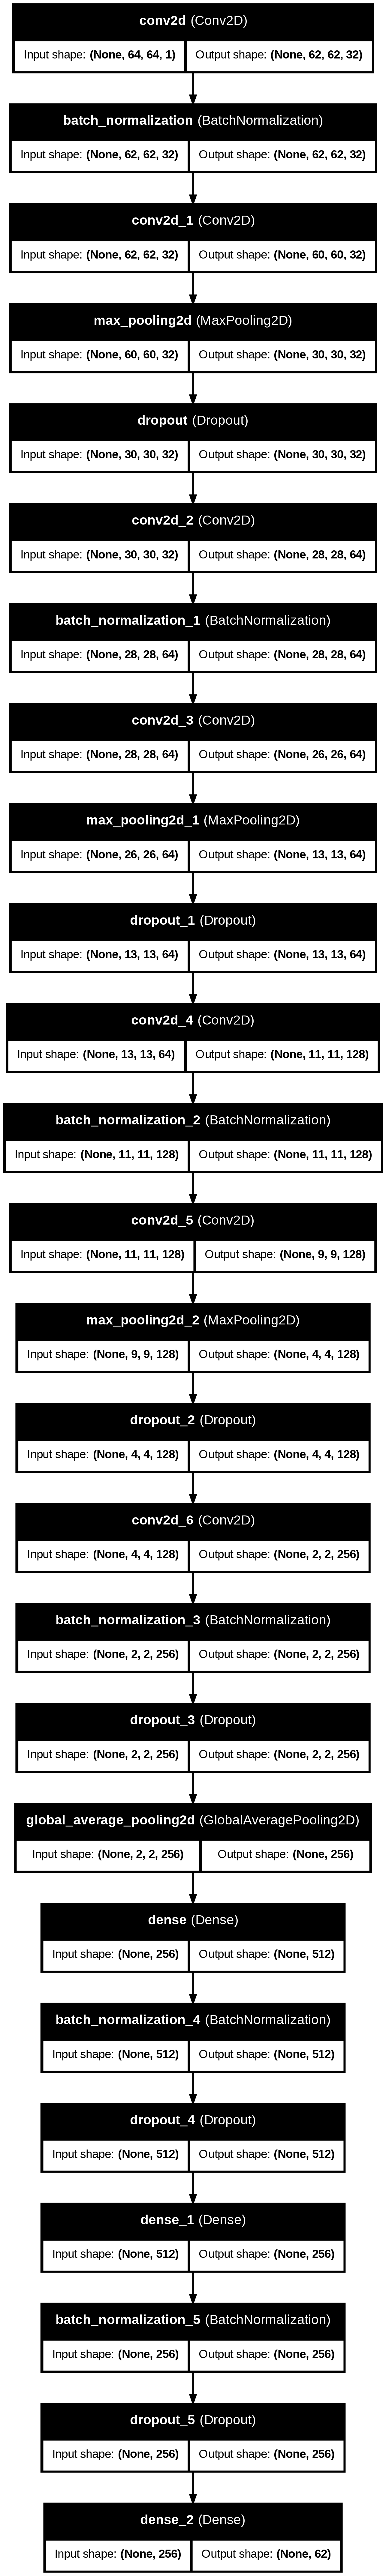

In [25]:
def create_advanced_cnn_model(input_shape, num_classes):
    """
    Create an advanced CNN model for character recognition
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # Global Average Pooling instead of Flatten to reduce parameters
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
input_shape = (64, 64, 1)
model = create_advanced_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

# Plot model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


Training Setup with Callbacks

In [26]:
# Create callbacks
callbacks_list = [
    # Early stopping
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate on plateau
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Model checkpoint
    callbacks.ModelCheckpoint(
        'best_ocr_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),

    # CSV logger
    callbacks.CSVLogger('training_log.csv')
]

# Calculate steps per epoch
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch: 74
Validation steps: 15


Model Training

In [27]:
# Train the model
print("Starting model training...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # We'll use early stopping, so this is the maximum
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=1
)

print("Training completed!")


Starting model training...
Epoch 1/50
72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.0295 - loss: 5.2985
Epoch 1: val_accuracy improved from -inf to 0.01667, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 173ms/step - accuracy: 0.0296 - loss: 5.2935 - val_accuracy: 0.0167 - val_loss: 4.6387 - learning_rate: 0.0010
Epoch 2/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0312 - loss: 5.2968
Epoch 2: val_accuracy did not improve from 0.01667
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0312 - loss: 5.2968 - val_accuracy: 0.0146 - val_loss: 4.6345 - learning_rate: 0.0010
Epoch 3/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0310 - loss: 4.7533
Epoch 3: val_accuracy did not improve from 0.01667
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.0313 - loss: 4.7491 - val_accuracy: 0.0167 - val_loss: 5.7442 - learning_rate: 0.0010
Epoch 4/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0625 - loss: 4.3817
Epoch 4: val_accuracy improved from 0.01667 to 0.02292, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0625 - loss: 4.3817 - val_accuracy: 0.0229 - val_loss: 5.7222 - learning_rate: 0.0010
Epoch 5/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0727 - loss: 4.1261
Epoch 5: val_accuracy did not improve from 0.02292
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0726 - loss: 4.1272 - val_accuracy: 0.0167 - val_loss: 6.6069 - learning_rate: 0.0010
Epoch 6/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0625 - loss: 4.2365
Epoch 6: val_accuracy did not improve from 0.02292
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0625 - loss: 4.2365 - val_accuracy: 0.0167 - val_loss: 6.6159 - learning_rate: 0.0010
Epoch 7/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1061 - loss: 3.8978
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_accuracy did not improve from 0.02292
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1061 - loss: 3.8963 - val_accuracy: 0.0167 

74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1946 - loss: 3.1363 - val_accuracy: 0.0354 - val_loss: 6.3829 - learning_rate: 2.5000e-04
Epoch 14/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0938 - loss: 2.8399
Epoch 14: val_accuracy did not improve from 0.03542
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0938 - loss: 2.8399 - val_accuracy: 0.0354 - val_loss: 6.3841 - learning_rate: 2.5000e-04
Epoch 15/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2267 - loss: 2.9931
Epoch 15: val_accuracy improved from 0.03542 to 0.05208, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2270 - loss: 2.9915 - val_accuracy: 0.0521 - val_loss: 5.0084 - learning_rate: 2.5000e-04
Epoch 16/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1250 - loss: 3.1206
Epoch 16: val_accuracy improved from 0.05208 to 0.05417, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1250 - loss: 3.1206 - val_accuracy: 0.0542 - val_loss: 4.9497 - learning_rate: 2.5000e-04
Epoch 17/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2526 - loss: 2.7867
Epoch 17: val_accuracy improved from 0.05417 to 0.14583, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.2524 - loss: 2.7873 - val_accuracy: 0.1458 - val_loss: 3.3880 - learning_rate: 2.5000e-04
Epoch 18/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3125 - loss: 2.7754
Epoch 18: val_accuracy improved from 0.14583 to 0.15833, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3125 - loss: 2.7754 - val_accuracy: 0.1583 - val_loss: 3.3403 - learning_rate: 2.5000e-04
Epoch 19/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2416 - loss: 2.7899
Epoch 19: val_accuracy improved from 0.15833 to 0.39375, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.2420 - loss: 2.7884 - val_accuracy: 0.3938 - val_loss: 2.2161 - learning_rate: 2.5000e-04
Epoch 20/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1875 - loss: 3.0122
Epoch 20: val_accuracy improved from 0.39375 to 0.40208, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1875 - loss: 3.0122 - val_accuracy: 0.4021 - val_loss: 2.1815 - learning_rate: 2.5000e-04
Epoch 21/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2827 - loss: 2.6095
Epoch 21: val_accuracy improved from 0.40208 to 0.44583, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.2829 - loss: 2.6086 - val_accuracy: 0.4458 - val_loss: 1.8879 - learning_rate: 2.5000e-04
Epoch 22/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3125 - loss: 2.2372
Epoch 22: val_accuracy did not improve from 0.44583
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3125 - loss: 2.2372 - val_accuracy: 0.4417 - val_loss: 1.9019 - learning_rate: 2.5000e-04
Epoch 23/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2990 - loss: 2.5582
Epoch 23: val_accuracy improved from 0.44583 to 0.48958, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2992 - loss: 2.5571 - val_accuracy: 0.4896 - val_loss: 1.7491 - learning_rate: 2.5000e-04
Epoch 24/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3438 - loss: 2.7865
Epoch 24: val_accuracy did not improve from 0.48958
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 2.7865 - val_accuracy: 0.4750 - val_loss: 1.7751 - learning_rate: 2.5000e-04
Epoch 25/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3267 - loss: 2.3758
Epoch 25: val_accuracy improved from 0.48958 to 0.55208, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3269 - loss: 2.3750 - val_accuracy: 0.5521 - val_loss: 1.5381 - learning_rate: 2.5000e-04
Epoch 26/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3438 - loss: 2.6446
Epoch 26: val_accuracy did not improve from 0.55208
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 2.6446 - val_accuracy: 0.5500 - val_loss: 1.5349 - learning_rate: 2.5000e-04
Epoch 27/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3833 - loss: 2.1812
Epoch 27: val_accuracy improved from 0.55208 to 0.63333, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3832 - loss: 2.1815 - val_accuracy: 0.6333 - val_loss: 1.3272 - learning_rate: 2.5000e-04
Epoch 28/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4375 - loss: 2.1604
Epoch 28: val_accuracy improved from 0.63333 to 0.63750, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4375 - loss: 2.1604 - val_accuracy: 0.6375 - val_loss: 1.2988 - learning_rate: 2.5000e-04
Epoch 29/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3751 - loss: 2.1215
Epoch 29: val_accuracy did not improve from 0.63750
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3754 - loss: 2.1215 - val_accuracy: 0.6083 - val_loss: 1.3191 - learning_rate: 2.5000e-04
Epoch 30/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4062 - loss: 2.1292
Epoch 30: val_accuracy did not improve from 0.63750
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4062 - loss: 2.1292 - val_accuracy: 0.6062 - val_loss: 1.3284 - learning_rate: 2.5000e-04
Epoch 31/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3728 - loss: 2.1703
Epoch 31: val_accuracy did not improve from 0.63750
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.3729 - loss: 2.1696 - val_accuracy: 0.5229 - val_loss: 1.5736 - learning_rate: 2.5000e-04
Epoch 32/50


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4529 - loss: 1.8755 - val_accuracy: 0.6479 - val_loss: 1.1461 - learning_rate: 1.2500e-04
Epoch 36/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4211 - loss: 1.9046
Epoch 36: val_accuracy improved from 0.64792 to 0.65208, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4211 - loss: 1.9046 - val_accuracy: 0.6521 - val_loss: 1.1371 - learning_rate: 1.2500e-04
Epoch 37/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4220 - loss: 1.8939
Epoch 37: val_accuracy improved from 0.65208 to 0.66250, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.4222 - loss: 1.8938 - val_accuracy: 0.6625 - val_loss: 1.0966 - learning_rate: 1.2500e-04
Epoch 38/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4062 - loss: 1.9870
Epoch 38: val_accuracy improved from 0.66250 to 0.67292, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4062 - loss: 1.9870 - val_accuracy: 0.6729 - val_loss: 1.0614 - learning_rate: 1.2500e-04
Epoch 39/50
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4546 - loss: 1.8275
Epoch 39: val_accuracy did not improve from 0.67292
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4546 - loss: 1.8276 - val_accuracy: 0.6354 - val_loss: 1.1647 - learning_rate: 1.2500e-04
Epoch 40/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5312 - loss: 1.5430
Epoch 40: val_accuracy did not improve from 0.67292
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 1.5430 - val_accuracy: 0.6396 - val_loss: 1.1419 - learning_rate: 1.2500e-04
Epoch 41/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4701 - loss: 1.7601
Epoch 41: val_accuracy improved from 0.67292 to 0.72708, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4703 - loss: 1.7601 - val_accuracy: 0.7271 - val_loss: 0.9183 - learning_rate: 1.2500e-04
Epoch 42/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3438 - loss: 1.9645
Epoch 42: val_accuracy improved from 0.72708 to 0.73333, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.9645 - val_accuracy: 0.7333 - val_loss: 0.9189 - learning_rate: 1.2500e-04
Epoch 43/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4910 - loss: 1.7100
Epoch 43: val_accuracy did not improve from 0.73333
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4909 - loss: 1.7105 - val_accuracy: 0.7104 - val_loss: 0.9872 - learning_rate: 1.2500e-04
Epoch 44/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4688 - loss: 1.6732
Epoch 44: val_accuracy did not improve from 0.73333
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4688 - loss: 1.6732 - val_accuracy: 0.7271 - val_loss: 0.9320 - learning_rate: 1.2500e-04
Epoch 45/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4664 - loss: 1.7465
Epoch 45: val_accuracy improved from 0.73333 to 0.74167, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4665 - loss: 1.7465 - val_accuracy: 0.7417 - val_loss: 0.8616 - learning_rate: 1.2500e-04
Epoch 46/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5938 - loss: 1.4739
Epoch 46: val_accuracy did not improve from 0.74167
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 1.4739 - val_accuracy: 0.7333 - val_loss: 0.8643 - learning_rate: 1.2500e-04
Epoch 47/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4844 - loss: 1.7159
Epoch 47: val_accuracy did not improve from 0.74167
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4846 - loss: 1.7158 - val_accuracy: 0.7292 - val_loss: 0.8895 - learning_rate: 1.2500e-04
Epoch 48/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5000 - loss: 1.5466
Epoch 48: val_accuracy did not improve from 0.74167
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 1.5466 - val_accuracy: 0.7167 - val_loss: 0.9036 - learning_rate: 1.2500e-04
Epoch 49/50


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5129 - loss: 1.5955 - val_accuracy: 0.7708 - val_loss: 0.7982 - learning_rate: 1.2500e-04
Epoch 50/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5312 - loss: 1.5397
Epoch 50: val_accuracy improved from 0.77083 to 0.78125, saving model to best_ocr_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5312 - loss: 1.5397 - val_accuracy: 0.7812 - val_loss: 0.7676 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 50.
Training completed!


Training Visualization

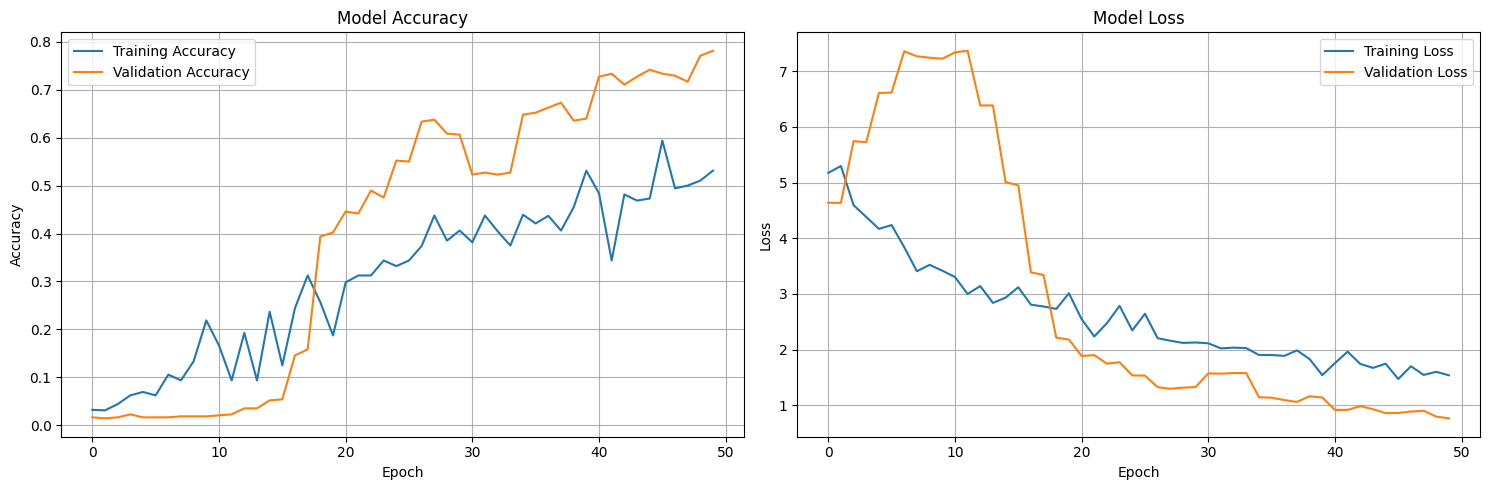

Final Training Accuracy: 0.5312
Final Validation Accuracy: 0.7812
Final Training Loss: 1.5397
Final Validation Loss: 0.7676


In [28]:
def plot_training_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

plot_training_history(history)


Model Evaluation

Evaluating model on test set...
Test Accuracy: 0.7676
Test Loss: 0.7777
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

=== Generating Demo Table Data ===

Demo Table Data for README:
| Input Description | Predicted Character | Confidence |
|------------------|-------------------|------------|
| Handwritten letter d | **d** | 99.6% |
| Handwritten letter Q | **Q** | 99.6% |
| Handwritten letter R | **R** | 99.6% |
| Handwritten letter S | **S** | 99.5% |
| Handwritten letter U | **U** | 99.3% |

Saving 5 demo images...
Demo data generation completed!
Demo images saved in 'demo/' folder

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.50      0.38      0.43         8
           2       0.86      0.75      0.80         8
           3       0.86      0.75      0.80         8
           4       0.75      0.75      0.75         8
           5       0.62      1.00      0.76         8
           6

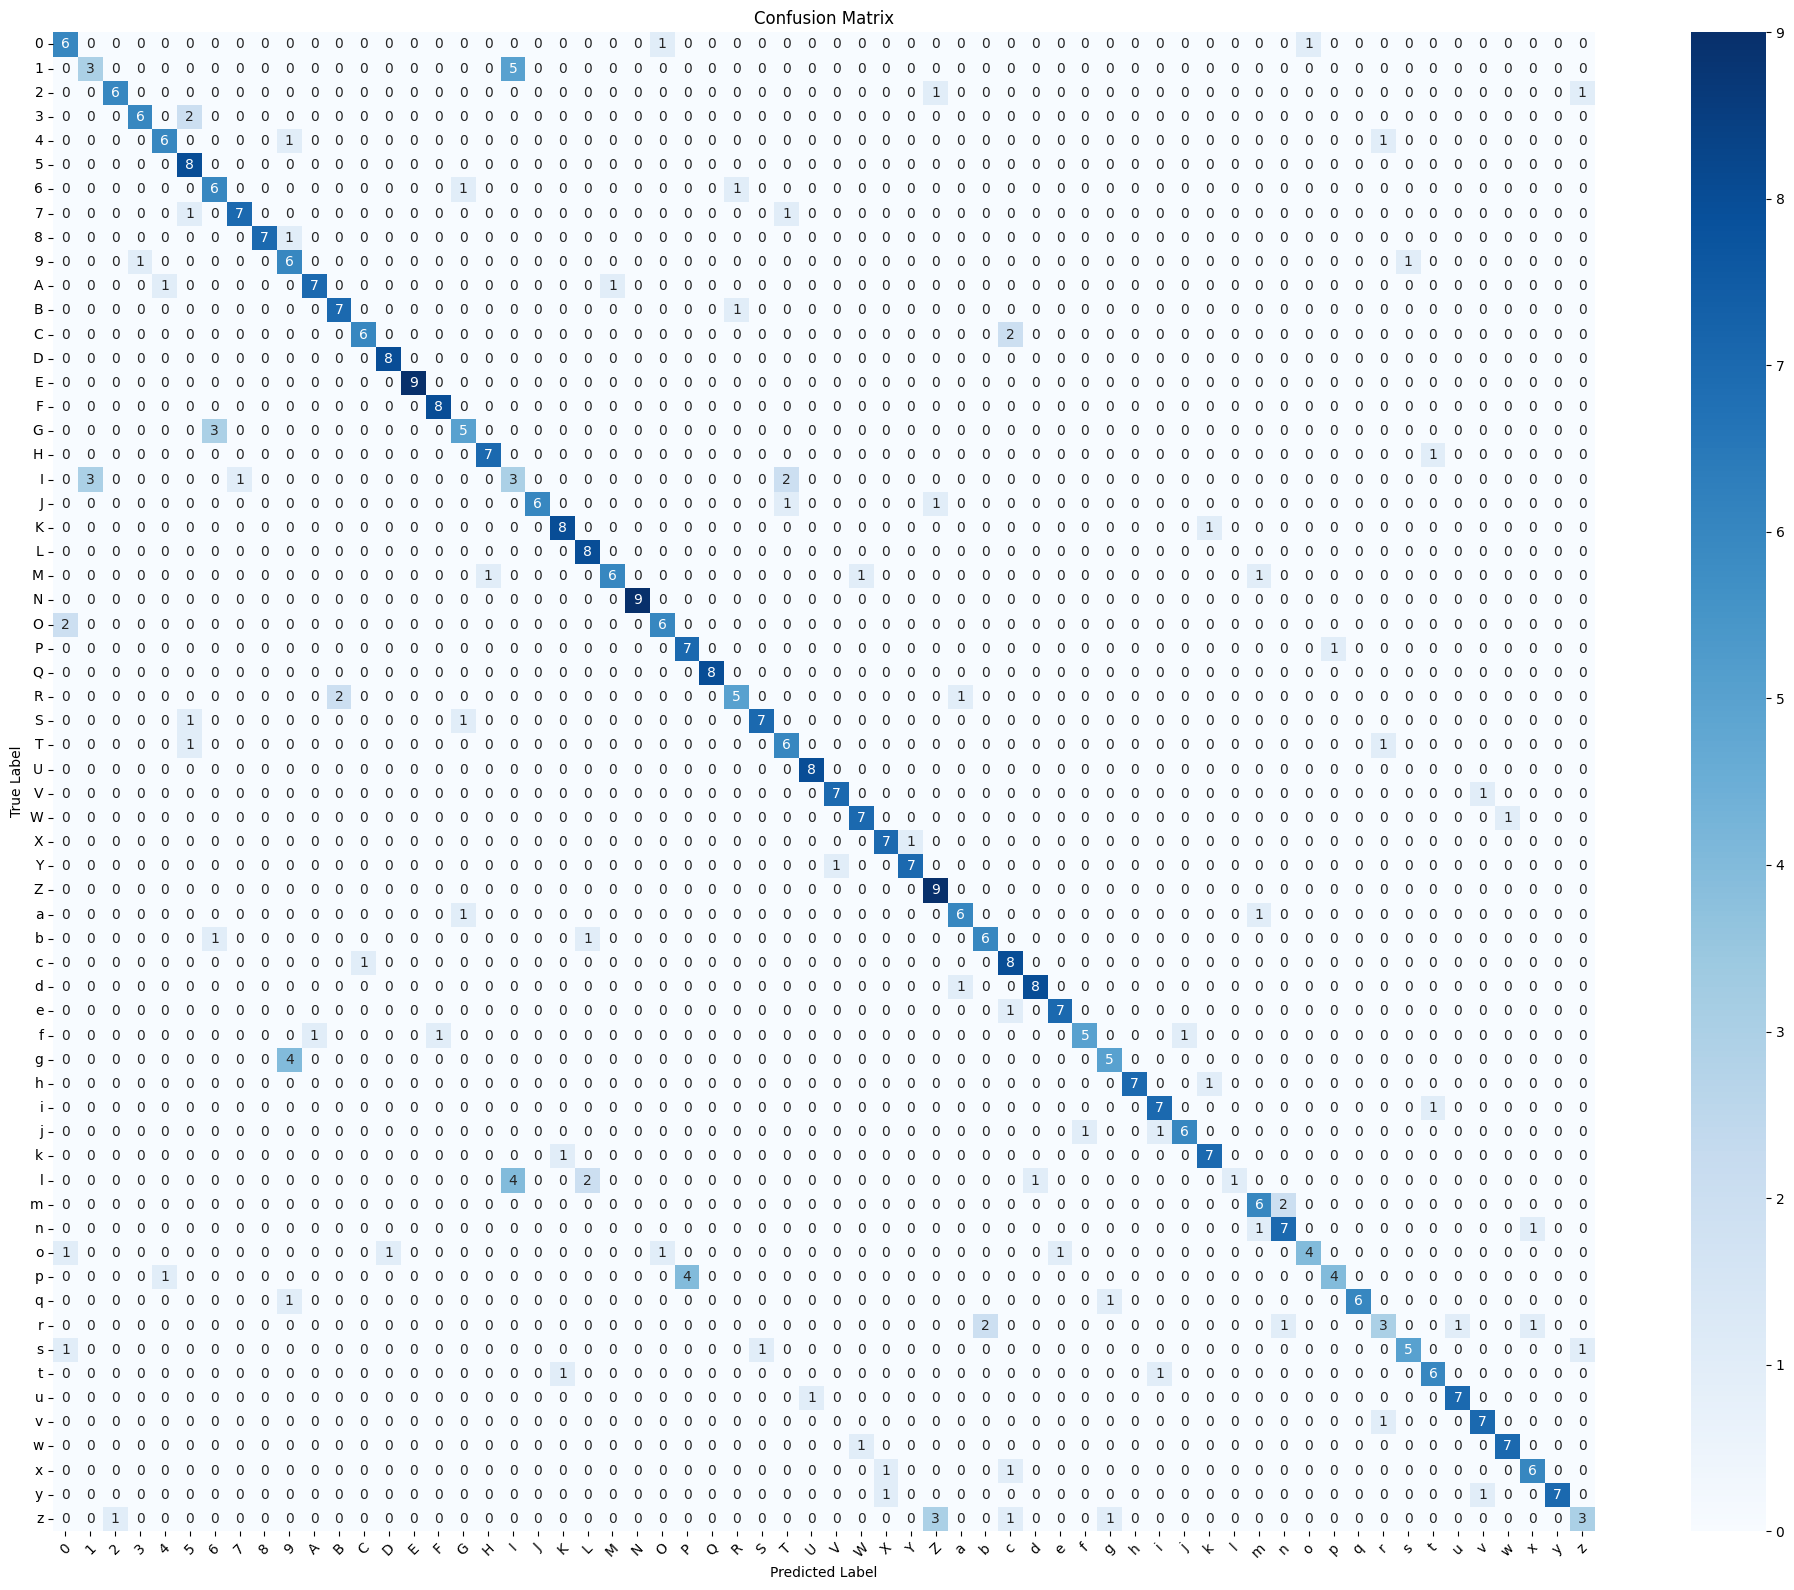


Per-class Accuracy (Bottom 10):
   Class  Accuracy
47     l  0.125000
18     I  0.333333
61     z  0.333333
1      1  0.375000
53     r  0.375000
51     p  0.444444
50     o  0.500000
42     g  0.555556
54     s  0.625000
41     f  0.625000

Per-class Accuracy (Top 10):
   Class  Accuracy
39     d  0.888889
13     D  1.000000
14     E  1.000000
15     F  1.000000
30     U  1.000000
26     Q  1.000000
21     L  1.000000
23     N  1.000000
5      5  1.000000
35     Z  1.000000


In [35]:
# Load the best model
best_model = tf.keras.models.load_model('best_ocr_model.h5')

# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# SELECT BEST EXAMPLES FOR DEMO TABLE
print("\n=== Generating Demo Table Data ===")

# Find high-confidence correct predictions
correct_predictions = []
for i in range(len(y_test)):
    confidence = np.max(y_pred[i])  # Use already computed predictions
    pred_class = y_pred_classes[i]

    if pred_class == y_test[i] and confidence > 0.85:  # High confidence + correct
        char_label = label_encoder.classes_[y_test[i]]
        correct_predictions.append((i, confidence, char_label))

# Sort by confidence and pick top examples
correct_predictions.sort(key=lambda x: x[1], reverse=True)

# Select diverse character types for demo
demo_examples = []
selected_chars = set()

# Try to get one example from each category
categories = {
    'digit': [str(i) for i in range(10)],
    'uppercase': [chr(i) for i in range(ord('A'), ord('Z')+1)],
    'lowercase': [chr(i) for i in range(ord('a'), ord('z')+1)]
}

for idx, confidence, char in correct_predictions:
    if len(demo_examples) >= 5:  # Limit to 5 examples
        break

    # Check if we need this character type
    char_category = None
    if char in categories['digit']:
        char_category = 'digit'
    elif char in categories['uppercase']:
        char_category = 'uppercase'
    elif char in categories['lowercase']:
        char_category = 'lowercase'

    if char not in selected_chars:
        demo_examples.append({
            'index': idx,
            'character': char,
            'confidence': confidence * 100,
            'category': char_category
        })
        selected_chars.add(char)

# Print demo table data
print("\nDemo Table Data for README:")
print("| Input Description | Predicted Character | Confidence |")
print("|------------------|-------------------|------------|")

for example in demo_examples:
    char = example['character']
    conf = example['confidence']
    category = example['category']

    if category == 'digit':
        desc = f"Handwritten number {char}"
    elif category == 'uppercase':
        desc = f"Handwritten letter {char}"
    else:
        desc = f"Handwritten letter {char}"

    print(f"| {desc} | **{char}** | {conf:.1f}% |")

# Save demo images
print(f"\nSaving {len(demo_examples)} demo images...")
import os
os.makedirs('demo', exist_ok=True)

for i, example in enumerate(demo_examples):
    idx = example['index']
    char = example['character']
    img = X_test[idx].squeeze()

    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray')
    plt.title(f"Character: {char} (Confidence: {example['confidence']:.1f}%)")
    plt.axis('off')
    plt.savefig(f'demo/sample_{char}.png', bbox_inches='tight', dpi=150, facecolor='white')
    plt.close()

print("Demo data generation completed!")
print("Demo images saved in 'demo/' folder")

# Classification report
class_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(20, 16)):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm

# Plot confusion matrix (this might be large due to 62 classes)
cm = plot_confusion_matrix(y_test, y_pred_classes, class_names)

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_acc_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': class_accuracy
}).sort_values('Accuracy')

print("\nPer-class Accuracy (Bottom 10):")
print(class_acc_df.head(10))
print("\nPer-class Accuracy (Top 10):")
print(class_acc_df.tail(10))


Prediction Visualization

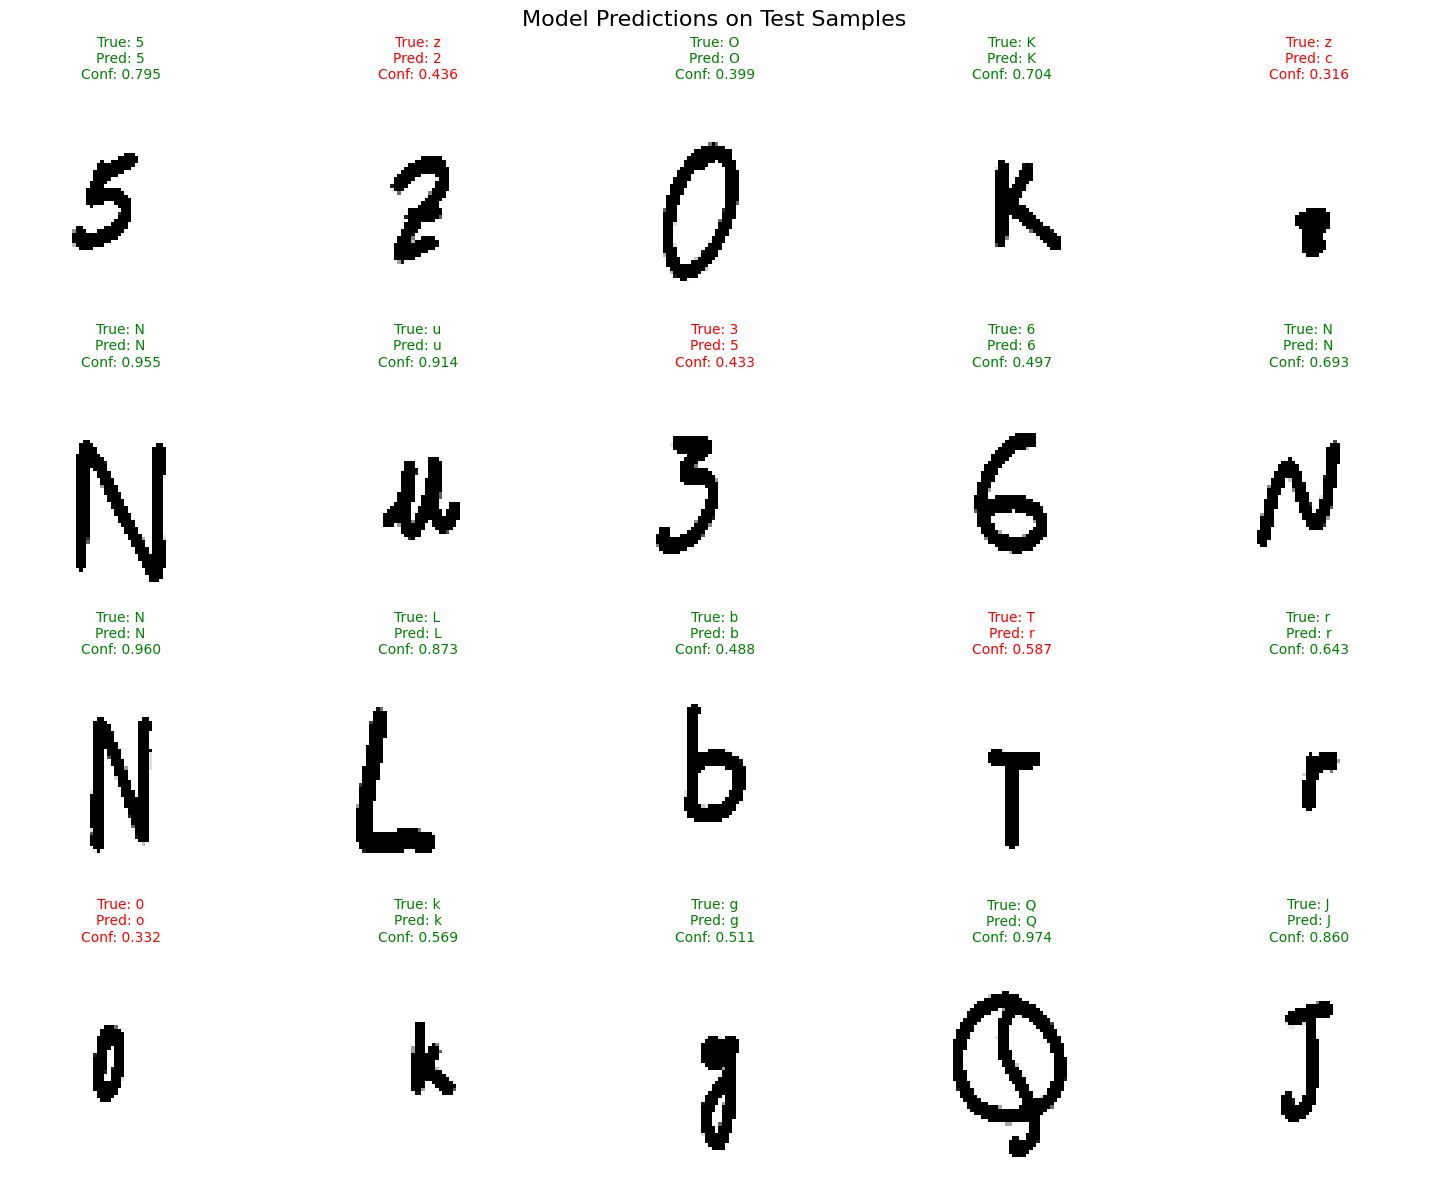

In [36]:
def visualize_predictions(model, X_test, y_test, y_pred_classes, label_encoder, num_samples=20):
    """
    Visualize model predictions
    """
    # Select random samples
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Model Predictions on Test Samples', fontsize=16)

    for i, idx in enumerate(indices):
        row = i // 5
        col = i % 5

        # Get image and predictions
        img = X_test[idx].squeeze()
        true_label = label_encoder.classes_[y_test[idx]]
        pred_label = label_encoder.classes_[y_pred_classes[idx]]
        confidence = np.max(y_pred[idx])

        # Plot image
        axes[row, col].imshow(img, cmap='gray')

        # Set title with prediction info
        color = 'green' if true_label == pred_label else 'red'
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                                color=color, fontsize=10)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(best_model, X_test, y_test, y_pred_classes, label_encoder)


Inference Function

In [31]:
def preprocess_image_for_prediction(image_path, target_size=(64, 64)):
    """
    Preprocess a single image for prediction
    """
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Resize image
    img_resized = cv2.resize(img, target_size)

    # Normalize pixel values
    img_normalized = img_resized.astype(np.float32) / 255.0

    # Add batch and channel dimensions
    img_batch = np.expand_dims(np.expand_dims(img_normalized, axis=-1), axis=0)

    return img_batch, img_resized

def predict_character(model, image_path, label_encoder, top_k=3):
    """
    Predict character from an image file
    """
    try:
        # Preprocess image
        img_batch, img_display = preprocess_image_for_prediction(image_path)

        # Make prediction
        predictions = model.predict(img_batch, verbose=0)

        # Get top-k predictions
        top_indices = np.argsort(predictions[0])[-top_k:][::-1]
        top_probs = predictions[0][top_indices]
        top_classes = [label_encoder.classes_[i] for i in top_indices]

        # Display results
        plt.figure(figsize=(10, 4))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(img_display, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        # Show predictions
        plt.subplot(1, 2, 2)
        y_pos = np.arange(len(top_classes))
        plt.barh(y_pos, top_probs)
        plt.yticks(y_pos, top_classes)
        plt.xlabel('Confidence')
        plt.title(f'Top {top_k} Predictions')
        plt.gca().invert_yaxis()

        plt.tight_layout()
        plt.show()

        return top_classes[0], top_probs[0]

    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

# Example usage (you can test this with any image)
print("Inference function created successfully!")
print("To use it, call: predict_character(best_model, 'path_to_image.jpg', label_encoder)")


Inference function created successfully!
To use it, call: predict_character(best_model, 'path_to_image.jpg', label_encoder)


Model Saving and Export

In [34]:
# Save the model in different formats
print("Saving model...")

# Save as .h5 format
best_model.save('best_ocr_model.h5')

# Save as .keras format (recommended modern format)
best_model.save('handwritten_character_ocr_model.keras')

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Model saved successfully!")

# Create a summary report
summary_report = f"""
# Handwritten Character Recognition OCR Model - Summary Report

## Dataset Information:
- Total Images: {len(X)}
- Number of Classes: {num_classes}
- Image Size: 64x64 pixels (grayscale)
- Classes: Digits (0-9), Uppercase (A-Z), Lowercase (a-z)

## Model Architecture:
- Type: Deep Convolutional Neural Network
- Total Parameters: {model.count_params():,}
- Input Shape: {input_shape}
- Output Classes: {num_classes}

## Training Configuration:
- Train/Validation/Test Split: 70%/15%/15%
- Batch Size: {batch_size}
- Data Augmentation: Yes (rotation, shift, shear, zoom)
- Optimizer: Adam (initial lr=0.001)
- Loss Function: Categorical Crossentropy

## Performance Metrics:
- Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
- Test Loss: {test_loss:.4f}
- Training Epochs: {len(history.history['accuracy'])}

## Files Generated:
- best_ocr_model.h5 (Best model during training)
- handwritten_character_ocr_model.keras (Final model - modern format)
- label_encoder.pkl (Label encoder for inference)
- training_log.csv (Training history)

## Usage:
The model can recognize handwritten characters with high accuracy.
Use the predict_character() function for inference on new images.
"""

print(summary_report)

# Save the summary report
with open('model_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("\nProject completed successfully!")
print("All files have been saved and the OCR system is ready for use.")


Saving model...
Model saved successfully!

# Handwritten Character Recognition OCR Model - Summary Report

## Dataset Information:
- Total Images: 3410
- Number of Classes: 62
- Image Size: 64x64 pixels (grayscale)
- Classes: Digits (0-9), Uppercase (A-Z), Lowercase (a-z)

## Model Architecture:
- Type: Deep Convolutional Neural Network
- Total Parameters: 865,438
- Input Shape: (64, 64, 1)
- Output Classes: 62

## Training Configuration:
- Train/Validation/Test Split: 70%/15%/15%
- Batch Size: 32
- Data Augmentation: Yes (rotation, shift, shear, zoom)
- Optimizer: Adam (initial lr=0.001)
- Loss Function: Categorical Crossentropy

## Performance Metrics:
- Test Accuracy: 0.7676 (76.76%)
- Test Loss: 0.7777
- Training Epochs: 50

## Files Generated:
- best_ocr_model.h5 (Best model during training)
- handwritten_character_ocr_model.keras (Final model - modern format)
- label_encoder.pkl (Label encoder for inference)
- training_log.csv (Training history)

## Usage:
The model can recognize